In [1]:
import os
import requests

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [185]:
import sys
sys.path.append('/project/svd-kernels')
from src.optimizers import SVDAdam, SVDSGD
from src.callbacks import OrthogonalityTracker, ConditioningTracker, DecompositionTracker
from src.layers import SVDDense

In [3]:
plt.style.use('dark_background')

# Benchmarking using UCI datasets

Benchmarking singular value decomposed kernels using UCI datasets. <br>
Comparing regular MLPs versus MLP with SVD kernels. <br>
* UCI ... dataset
* UCI ... dataset

In [4]:
uci_directory = "https://archive.ics.uci.edu/ml/machine-learning-databases"

## Adult Data

In [366]:
data_name = 'adult'

### Data loading

In [362]:
# Get information about dataset
information = requests.get(os.path.join(uci_directory, data_name, data_name + '.names'))
# print(information.content.decode('utf-8'))

In [367]:
# Columns extracted from information (manual)
# names =  ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs' ,'restecg', 'thalach', 'exang','oldpeak','slope','ca','thal', 'num']
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 
         'race', 'sex', 'capital-gain', 'captial-loss', 'hours-per-week', 'native-country', '50K']
# Read data
df = pd.read_csv(os.path.join(uci_directory, data_name, data_name + '.data'), encoding = 'latin', names=names, index_col=False, na_values='?')
# drop nan's
df = df.dropna()
# Get categorical features (5 is maximal number of discrete values --> taken from information)
categorical_columns = [col for col in df if np.unique(df[col]).size < 50]
# Get numerical features
numerical_columns = [col for col in df if col not in categorical_columns]
# Convert to correct dtype
df[numerical_columns] = df[numerical_columns].astype(float)
# Show data header
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,50K
0,39.0,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Visualization

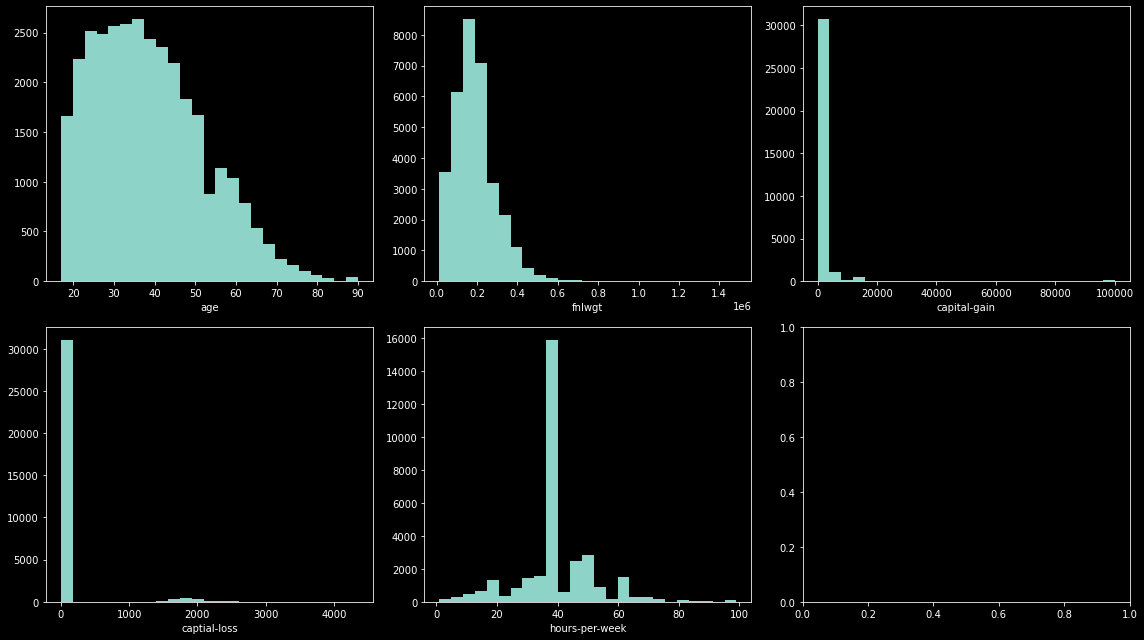

In [368]:
rows = int(np.sqrt(len(numerical_columns)))
cols = int(np.ceil(len(numerical_columns)/rows))
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for ax, col in zip(axes.reshape(-1)[:len(numerical_columns)], numerical_columns):
    ax.hist(df[col].values, bins=25)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

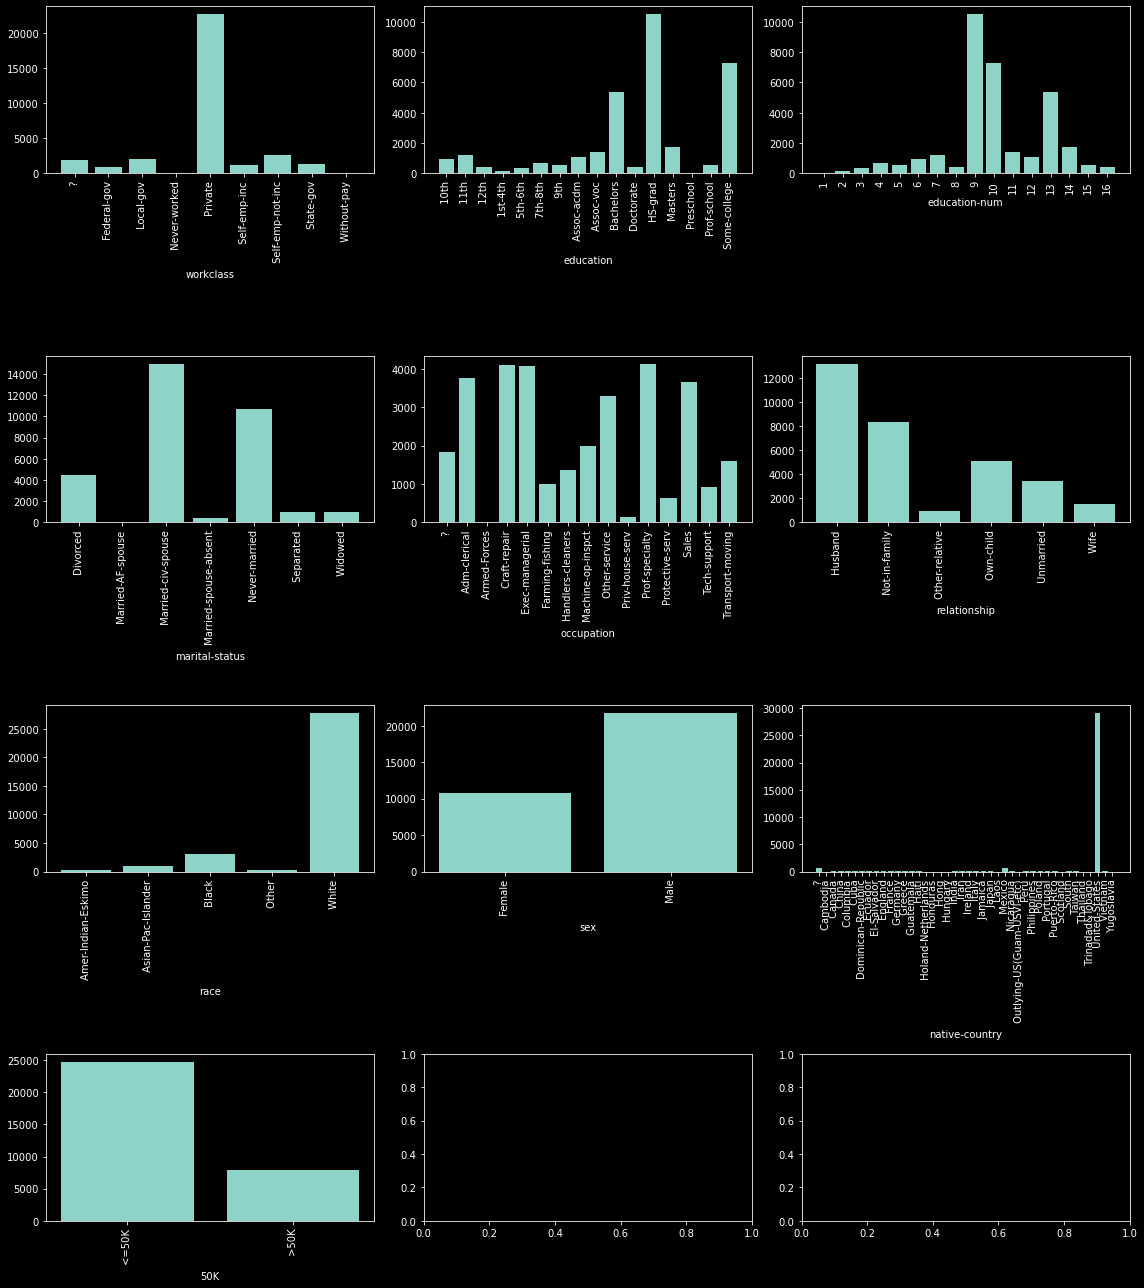

In [369]:
cols = int(np.sqrt(len(categorical_columns)))
cols = 3
rows = int(np.ceil(len(categorical_columns)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(16, 18))
for ax, col in zip(axes.reshape(-1)[:len(categorical_columns)], categorical_columns):
    values, counts = np.unique(df[col].values, return_counts=True)
    ax.bar(values, counts)
    ax.set_xticks(values)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

### Preprocessing

In [318]:
from sklearn.preprocessing import quantile_transform

In [319]:
# Encode categorical variables
df = pd.get_dummies(df, columns=categorical_columns)
# Normalize features
df[numerical_columns] = quantile_transform(df[numerical_columns], n_quantiles=25, output_distribution='normal')
# Show data header
df.head(1)

,age,fnlwgt,capital-gain,captial-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,50K_ <=50K,50K_ >50K
0,0.104633,-1.171915,1.468964,-5.199338,-0.104633,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Data pipeline

In [320]:
from sklearn.model_selection import train_test_split

In [321]:
# Get target columns
target_columns = [col for col in df if '50K' in col]
x, y = df.drop(target_columns, axis=1).values, df[target_columns].values[:, 0]
# Split data
split = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, shuffle=True)

In [322]:
batch_size = 32
buffer_size = batch_size * 128
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(32, 123) (32,)


### Model

In [396]:
# Parameters for model architecture
n_layers = 2
units = [64 for _ in range(n_layers)]
ranks = [32 for _ in range(n_layers)]
activation = 'tanh'

In [397]:
def build_model(units, ranks=None):
    # Empty layers list
    layers = [None] * len(units)
    # Make layers
    if ranks is None:
        for idx, unit in enumerate(units):
            layers[idx] = tf.keras.layers.Dense(unit, activation)  
    else:
        assert len(ranks) == len(units)
        for idx, (unit, rank) in enumerate(zip(units, ranks)):
            layers[idx] = SVDDense(unit, rank, activation)
    # Make input layer
    inputs = tf.keras.Input(shape=x.shape[1:])
    hidden = tf.keras.layers.Dense(units[0], activation)(inputs)
    # hidden layers
    for layer in layers:
        hidden = layer(hidden)
    # Projectionl layer
    outputs = tf.keras.layers.Dense(1, 'sigmoid')(hidden)
    # Make & compile model
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [398]:
# Number of epochs
epochs = 10
# Learning rates
learning_rate = 2*10e-5
nu = 2*10e-5
# acceleration parameters
beta = 0.9
gamma = 0.999

# Loss and accuracy
loss_fn = tf.keras.losses.BinaryCrossentropy()
accuracy_fn = tf.keras.metrics.BinaryAccuracy()

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy', mode='max', verbose=1, patience=3)

In [399]:
decomposition_tracker = DecompositionTracker(on_batch=True)

In [400]:
# Make model
model = build_model(units)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Callbacks
callbacks = [early_stopping, decomposition_tracker]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/10
814/814 [==============================] - 17s 20ms/step - loss: 0.4094 - binary_accuracy: 0.8074 - val_loss: 0.3398 - val_binary_accuracy: 0.8440
Epoch 2/10
814/814 [==============================] - 16s 20ms/step - loss: 0.3340 - binary_accuracy: 0.8453 - val_loss: 0.3353 - val_binary_accuracy: 0.8455
Epoch 3/10
814/814 [==============================] - 16s 20ms/step - loss: 0.3295 - binary_accuracy: 0.8467 - val_loss: 0.3332 - val_binary_accuracy: 0.8455
Epoch 4/10
814/814 [==============================] - 16s 20ms/step - loss: 0.3273 - binary_accuracy: 0.8478 - val_loss: 0.3319 - val_binary_accuracy: 0.8466
Epoch 5/10
814/814 [==============================] - 16s 20ms/step - loss: 0.3255 - binary_accuracy: 0.8490 - val_loss: 0.3308 - val_binary_accuracy: 0.8471
Epoch 6/10
814/814 [==============================] - 16s 20ms/step - loss: 0.3240 - binary_accuracy: 0.8495 - val_loss: 0.3299 - val_binary_accuracy: 0.8475
Epoch 7/10
814/814 [==============================] 

In [401]:
# Make trackers
orthogonality_tracker = OrthogonalityTracker(on_batch=True)
conditioning_tracker = ConditioningTracker(on_batch=True)

In [402]:
# Make model
model = build_model(units, [i for i in ranks])
# SVD optimizer
optimizer = SVDSGD(model, learning_rate/100000, nu/100000, beta, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks = [early_stopping, orthogonality_tracker, conditioning_tracker]
# Train model
history_ = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/10
814/814 [==============================] - 10s 11ms/step - loss: 7360.7784 - binary_accuracy: 0.4885 - val_loss: 30436.9238 - val_binary_accuracy: 0.2365
Epoch 2/10
814/814 [==============================] - 8s 10ms/step - loss: 37585.0736 - binary_accuracy: 0.2463 - val_loss: 61063.7578 - val_binary_accuracy: 0.2365
Epoch 3/10
814/814 [==============================] - 8s 10ms/step - loss: 67814.8614 - binary_accuracy: 0.2463 - val_loss: 91690.5469 - val_binary_accuracy: 0.2365
Epoch 4/10
814/814 [==============================] - 8s 10ms/step - loss: 98044.6091 - binary_accuracy: 0.2463 - val_loss: 122317.3906 - val_binary_accuracy: 0.2365
Epoch 00004: early stopping


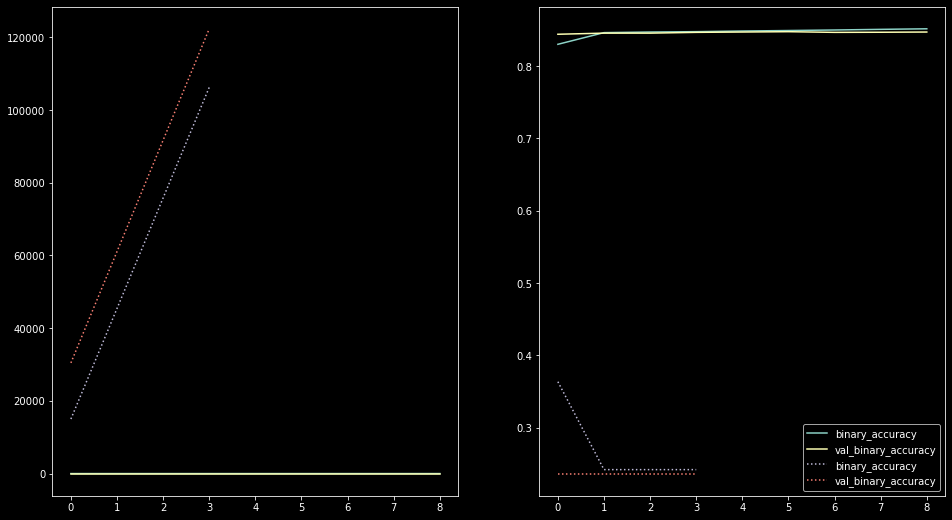

In [406]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for key, value in history.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key)
for key, value in history_.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key, linestyle='dotted')
plt.legend()
plt.show()

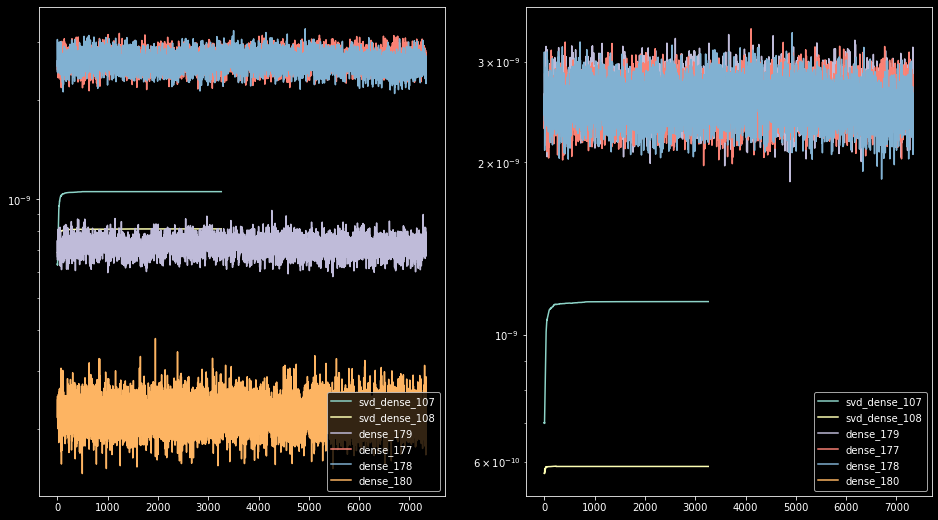

In [407]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        axes[0].plot(orthogonality_tracker.kappa[layer.name]['u'], label=layer.name)
        axes[1].plot(orthogonality_tracker.kappa[layer.name]['v'], label=layer.name)
for layer, values in decomposition_tracker.kappa.items():
    axes[0].plot(values['u'], label=layer)
    axes[1].plot(values['v'], label=layer)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

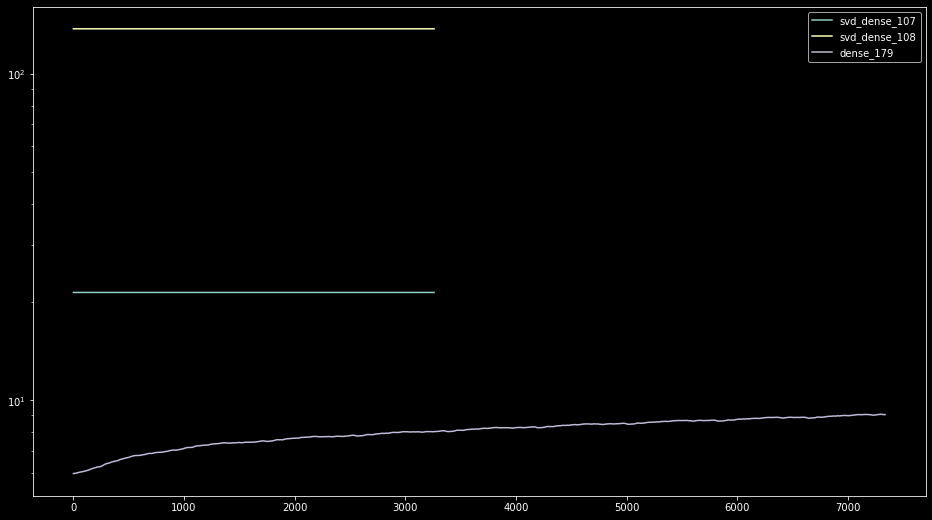

In [408]:
fig, axes = plt.subplots(1,1, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        plt.plot(conditioning_tracker.kappa[layer.name], label=layer.name)
for layer, values in decomposition_tracker.kappa.items():
    plt.plot(values['s'], label=layer)
    break
plt.yscale('log')
plt.legend()
plt.show()

### Optimizers

In [181]:
models = {}
histories = {}
trackers = {}

**Regular SGD**

In [182]:
decomposition_tracker = DecompositionTracker(on_batch=True)

In [186]:
# Make model
model = build_model(units)
# SVD optimizer
optimizer = SVDSGD(model, learning_rate, nu, 0.0, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks = [early_stopping, decomposition_tracker]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

KeyboardInterrupt: 

In [ ]:
key = 'Regular, SGD'
models[key] = model
histories[key] = history
trackers[key] = callbacks

**Regular SGD + Momentum**

In [ ]:
decomposition_tracker = DecompositionTracker(on_batch=True)

In [ ]:
# Make model
model = build_model(units)
# SVD optimizer
optimizer = SVDSGD(model, learning_rate, nu, beta, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks = [early_stopping, decomposition_tracker]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

In [ ]:
key = 'Regular, SGD + MOM'
models[key] = model
histories[key] = history
trackers[key] = callbacks

**Regular ADAM**

In [175]:
decomposition_tracker = DecompositionTracker(on_batch=True)

In [ ]:
# Make model
model = build_model(units)
# SVD optimizer
optimizer = SVDADAM(model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks = [early_stopping, decomposition_tracker]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

In [ ]:
key = 'Regular, ADAM'
models[key] = model
histories[key] = history
trackers[key] = callbacks

**SVD SGD**

In [ ]:
# Make trackers
orthogonality_tracker = OrthogonalityTracker(on_batch=True)
conditioning_tracker = ConditioningTracker(on_batch=True)

In [ ]:
# Make model
model = build_model(units, ranks)
# SVD optimizer
optimizer = SVDSGD(model, learning_rate, nu, 0.0, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks = [early_stopping, orthogonality_tracker, conditioning_tracker]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

In [ ]:
key = 'SVD, SGD'
models[key] = model
histories[key] = history
trackers[key] = callbacks

**SVD SGD + Momentum**

In [ ]:
# Make trackers
orthogonality_tracker = OrthogonalityTracker(on_batch=True)
conditioning_tracker = ConditioningTracker(on_batch=True)

In [ ]:
# Make model
model = build_model(units, ranks)
# SVD optimizer
optimizer = SVDSGD(model, learning_rate, nu, beta, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks = [early_stopping, orthogonality_tracker, conditioning_tracker]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

In [ ]:
key = 'Regular, SGD + MOM'
models[key] = model
histories[key] = history
trackers[key] = callbacks

**SVD ADAM**

In [ ]:
# Make trackers
orthogonality_tracker = OrthogonalityTracker(on_batch=True)
conditioning_tracker = ConditioningTracker(on_batch=True)

In [ ]:
# Make model
model = build_model(units, ranks)
# SVD optimizer
optimizer = SVDADAM(model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks = [early_stopping, orthogonality_tracker, conditioning_tracker]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

In [ ]:
key = 'Regular, ADAM'
models[key] = model
histories[key] = history
trackers[key] = callbacks

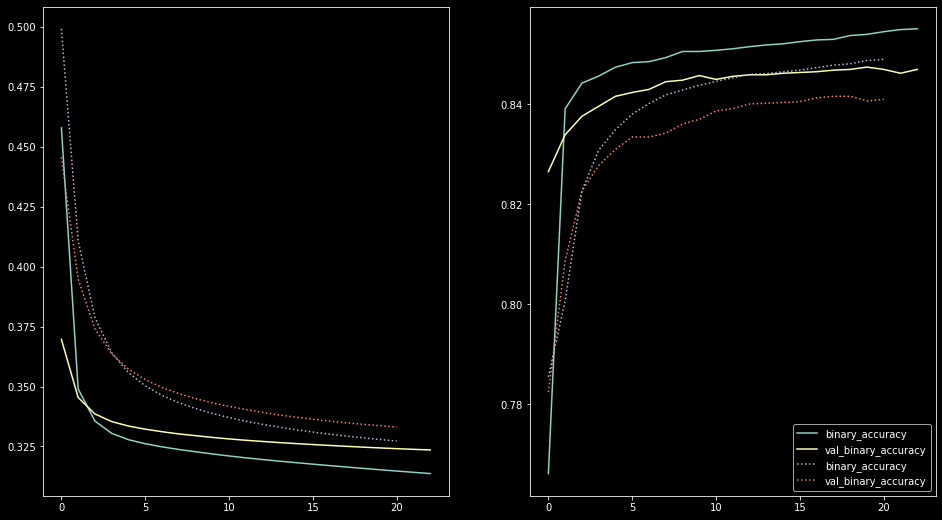

In [165]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for name, history in histories.items():
    if 'svd' in name':
        linestyle='dotted'
    else:
        linestyle='solid'
    for key, value in history.history.items():
        i = 0 if 'loss' in key else 1
        axes[i].plot(value, label=key, linestyle=linestyle)
plt.legend()
plt.show()

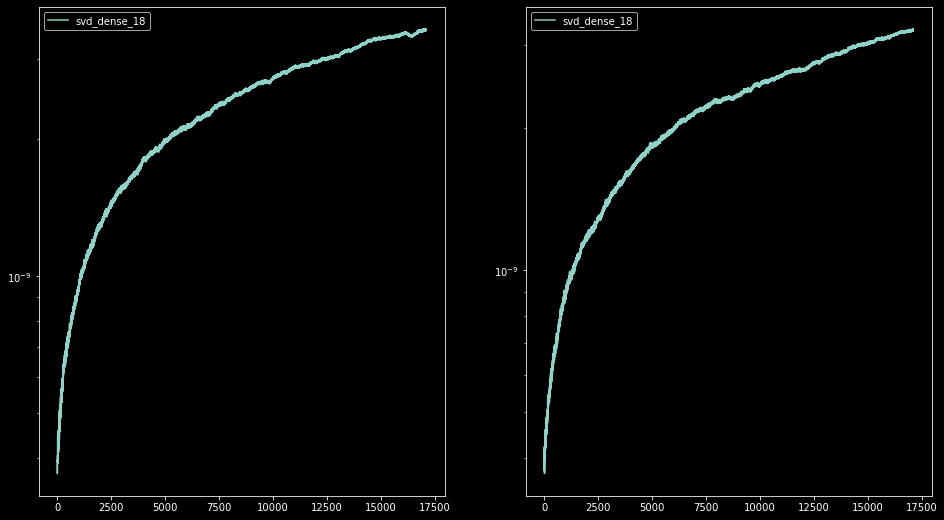

In [166]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        axes[0].plot(orthogonality_tracker.kappa[layer.name]['u'], label=layer.name)
        axes[1].plot(orthogonality_tracker.kappa[layer.name]['v'], label=layer.name)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

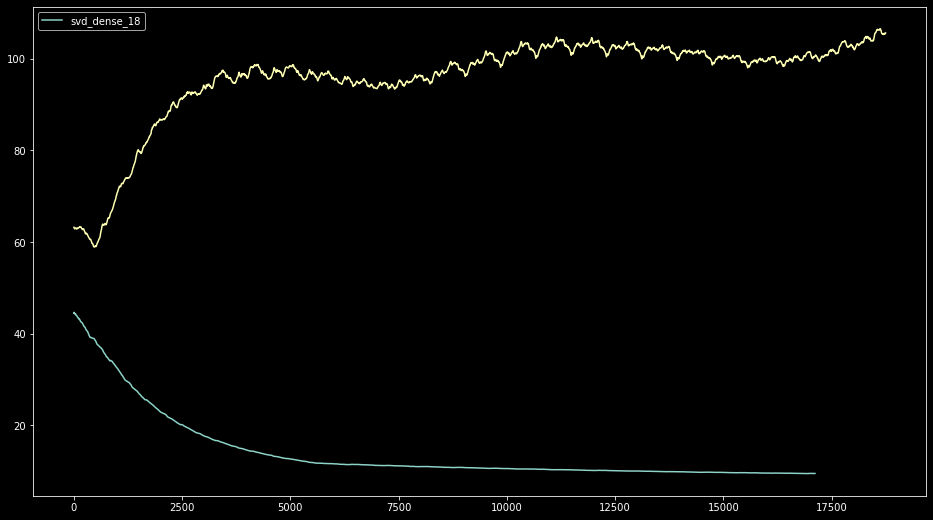

In [167]:
fig, axes = plt.subplots(1,1, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        plt.plot(conditioning_tracker.kappa[layer.name], label=layer.name)
plt.plot(decomposition_tracker.kappa[list(decomposition_tracker.kappa.keys())[0]]['s'])
plt.legend()
plt.show()

## IRIS Data

In [5]:
data_name = 'iris'

### Data loading

In [7]:
# Get information about dataset
information = requests.get(os.path.join(uci_directory, data_name, data_name + '.names'))
print(information.content.decode('utf-8'))

1. Title: Iris Plants Database
	Updated Sept 21 by C.Blake - Added discrepency information

2. Sources:
     (a) Creator: R.A. Fisher
     (b) Donor: Michael Marshall (MARSHALL%PLU@io.arc.nasa.gov)
     (c) Date: July, 1988

3. Past Usage:
   - Publications: too many to mention!!!  Here are a few.
   1. Fisher,R.A. "The use of multiple measurements in taxonomic problems"
      Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions
      to Mathematical Statistics" (John Wiley, NY, 1950).
   2. Duda,R.O., & Hart,P.E. (1973) Pattern Classification and Scene Analysis.
      (Q327.D83) John Wiley & Sons.  ISBN 0-471-22361-1.  See page 218.
   3. Dasarathy, B.V. (1980) "Nosing Around the Neighborhood: A New System
      Structure and Classification Rule for Recognition in Partially Exposed
      Environments".  IEEE Transactions on Pattern Analysis and Machine
      Intelligence, Vol. PAMI-2, No. 1, 67-71.
      -- Results:
         -- very low misclassification rates (0% for t

In [12]:
# Columns extracted from information (manual)
# names =  ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs' ,'restecg', 'thalach', 'exang','oldpeak','slope','ca','thal', 'num']
names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
# Read data
df = pd.read_csv(os.path.join(uci_directory, data_name, data_name + '.data'), encoding = 'latin', names=names, index_col=False, na_values='?')
# drop nan's
df = df.dropna()
# Get categorical features (5 is maximal number of discrete values --> taken from information)
categorical_columns = [col for col in df if np.unique(df[col]).size < 10]
# Get numerical features
numerical_columns = [col for col in df if col not in categorical_columns]
# Convert to correct dtype
df[numerical_columns] = df[numerical_columns].astype(float)
# Show data header
df.head(1)

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa


### Visualization

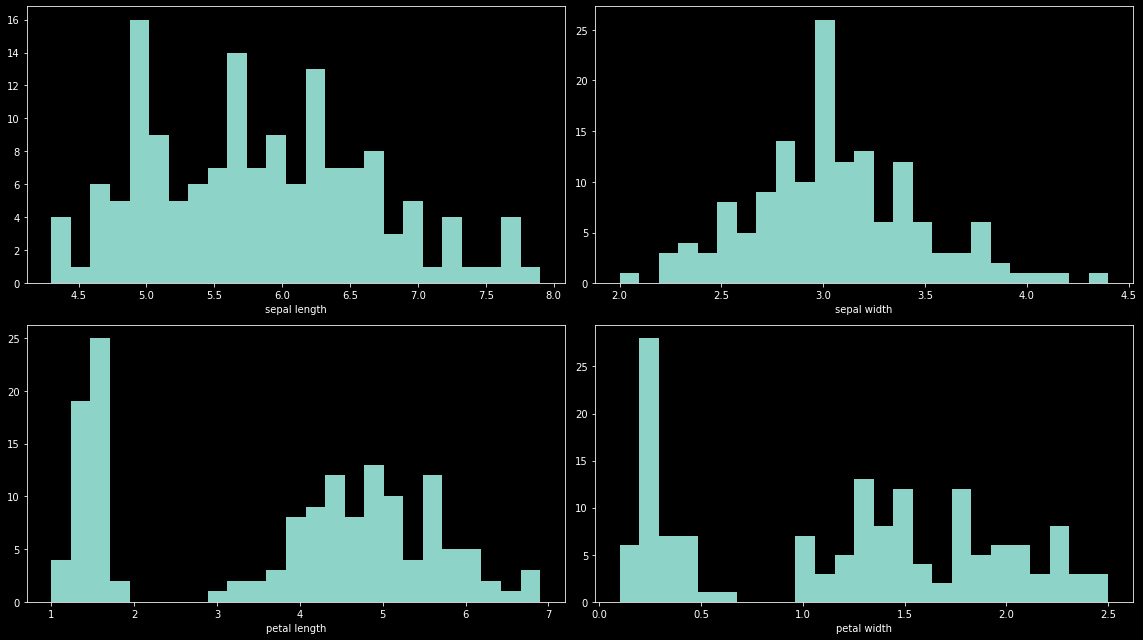

In [13]:
rows = int(np.sqrt(len(numerical_columns)))
cols = int(np.ceil(len(numerical_columns)/rows))
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for ax, col in zip(axes.reshape(-1)[:len(numerical_columns)], numerical_columns):
    ax.hist(df[col].values, bins=25)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

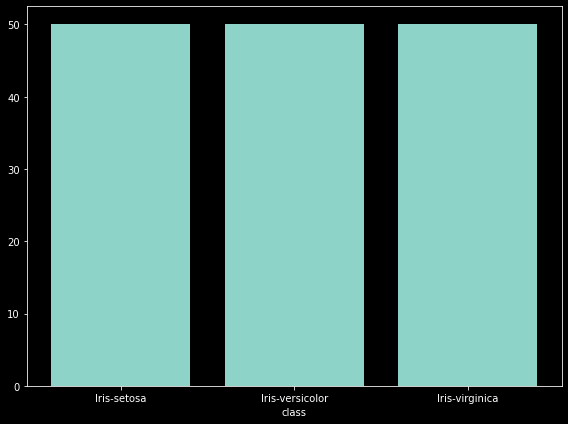

In [22]:
cols = int(np.sqrt(len(categorical_columns)))
rows = int(np.ceil(len(categorical_columns)/cols))
fig, ax = plt.subplots(rows, cols, figsize=(8, 6))
values, counts = np.unique(df['class'].values, return_counts=True)
ax.bar(values, counts)
ax.set_xticks(values)
ax.xaxis.set_tick_params(rotation=0)
ax.set_xlabel(col)
plt.tight_layout()
plt.show()

### Preprocessing

In [23]:
from sklearn.preprocessing import quantile_transform

In [24]:
# Encode categorical variables
df = pd.get_dummies(df, columns=categorical_columns)
# Normalize features
df[numerical_columns] = quantile_transform(df[numerical_columns], n_quantiles=25, output_distribution='normal')
# Show data header
df.head(1)

,sepal length,sepal width,petal length,petal width,class_Iris-setosa,class_Iris-versicolor,class_Iris-virginica
0,-0.67449,1.150349,-1.258162,-1.150349,1,0,0


### Data pipeline

In [25]:
from sklearn.model_selection import train_test_split

In [28]:
# Get target columns
target_columns = [col for col in df if 'class' in col]
x, y = df.drop(target_columns, axis=1).values, df[target_columns].values
# Split data
split = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, shuffle=True)

In [59]:
batch_size = 16
buffer_size = batch_size * 128
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(16, 4) (16, 3)


### Model

In [60]:
# Parameters for model architecture
units = [16]
ranks = [8]
activation = 'elu'

In [61]:
def build_model(units, ranks=None):
    # Empty layers list
    layers = [None] * len(units)
    # Make layers
    if ranks is None:
        for idx, unit in enumerate(units):
                    layers[idx] = tf.keras.layers.Dense(unit, activation)  
    else:
        assert len(ranks) == len(units)
        for idx, (unit, rank) in enumerate(zip(units, ranks)):
            layers[idx] = SVDDense(unit, rank, activation)
    # Make input layer
    inputs = tf.keras.Input(shape=x.shape[1:])
    hidden = inputs
    # hidden layers
    for layer in layers:
        hidden = layer(hidden)
    # Projectionl layer
    outputs = tf.keras.layers.Dense(3, 'softmax')(hidden)
    # Make & compile model
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [62]:
# Number of epochs
epochs = 50
# Learning rates
learning_rate = 10e-5
nu = 10e-5
# acceleration parameters
beta = 0.9
gamma = 0.999

# Loss and accuracy
loss_fn = tf.keras.losses.CategoricalCrossentropy()
accuracy_fn = tf.keras.metrics.CategoricalAccuracy()

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', mode='max', verbose=1, patience=3)

In [69]:
# Make model
model = build_model(units)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Callbacks
callbacks = [early_stopping, DecompositionTracker(on_batch=True)]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

Epoch 00004: early stopping


In [64]:
# Make trackers
orthogonality_tracker = OrthogonalityTracker(on_batch=True)
conditioning_tracker = ConditioningTracker(on_batch=True)

In [65]:
# Make model
model = build_model(units, ranks)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks += [orthogonality_tracker, conditioning_tracker]
# Train model
history_ = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

Epoch 00006: early stopping


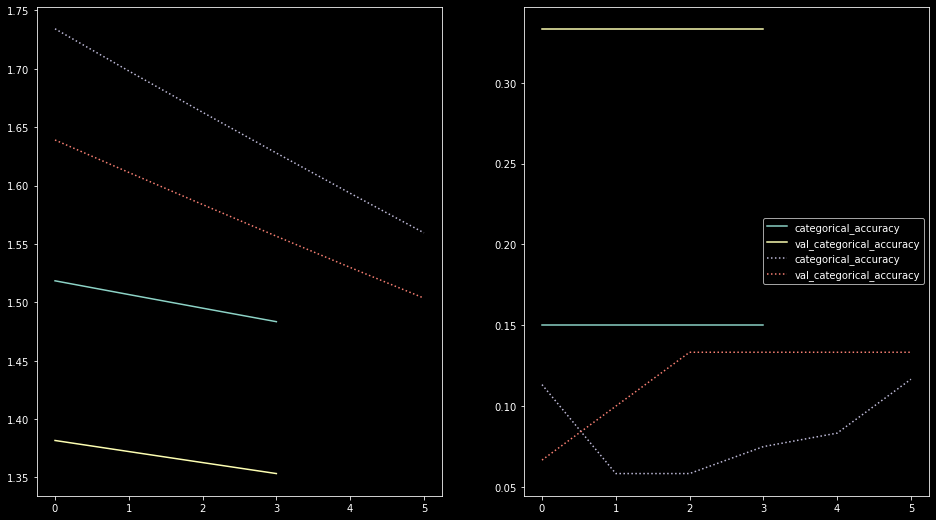

In [66]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for key, value in history.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key)
for key, value in history_.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key, linestyle='dotted')
plt.legend()
plt.show()

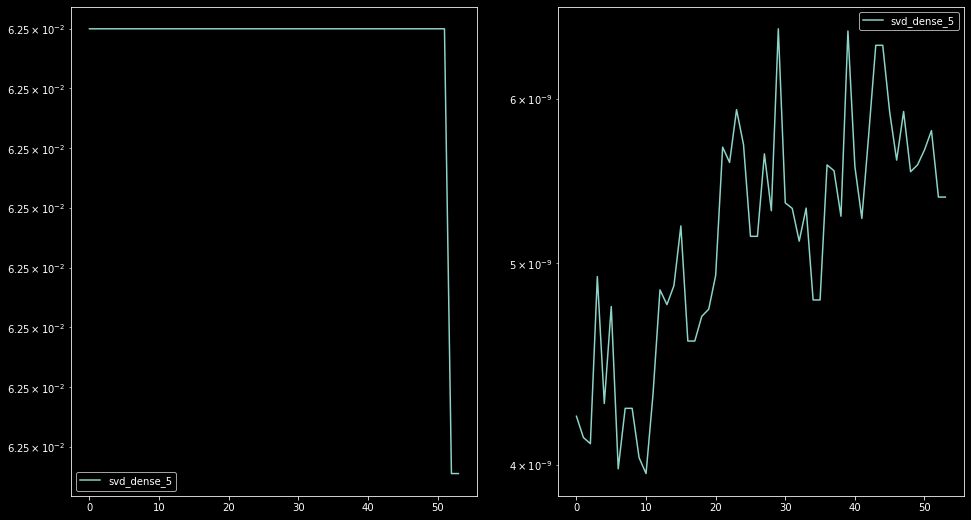

In [67]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        axes[0].plot(orthogonality_tracker.kappa[layer.name]['u'], label=layer.name)
        axes[1].plot(orthogonality_tracker.kappa[layer.name]['v'], label=layer.name)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

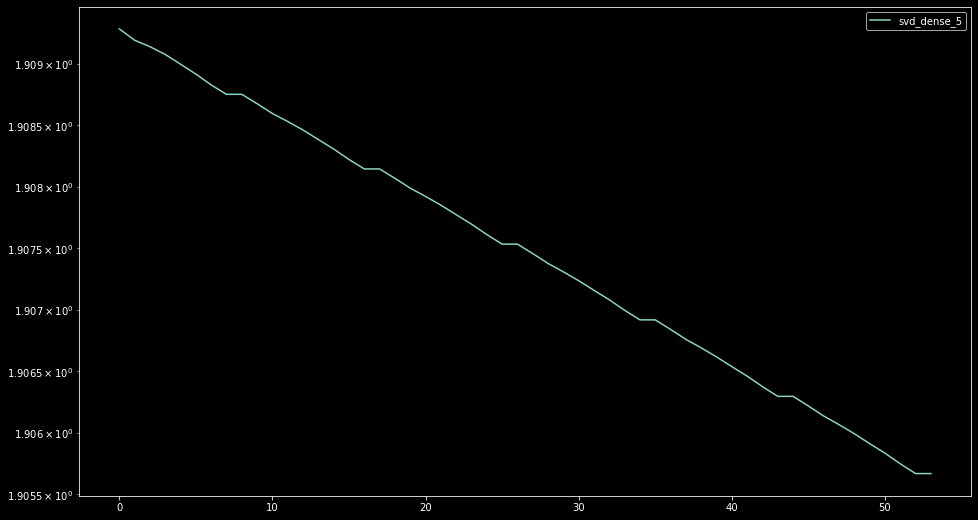

In [68]:
fig, axes = plt.subplots(1,1, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        plt.plot(conditioning_tracker.kappa[layer.name], label=layer.name)
plt.yscale('log')
plt.legend()
plt.show()